<DIV ALIGN=CENTER>

# Introduction to Regression
## Professor Robert J. Brunner
  
</DIV>  
-----
-----

## Introduction

In previos notebooks, we have used the Unix command line to explore a
data set and subsequently used Python to summarize and visually explore a
data set. In some of these visualizations, the data demonstrated definite
trends between one or more variables. These visual representations are
useful in understanding data, but we often want to model the data in
order (1) to extract a physical understanding of the trends and (b) to
predict future responses given new data. For example, we might want to
predict the actual arrival time for flights based on previous flight
data. Alternatively we might want to investigate the physical reasons for
specific flights or airports that show excessive departure or arrival
delays.

In this notebook, we introduce the concept of regression. We can use
regression to _fit a model to data_. The resulting model can be explored
in greater detail to understand why the data follow the model, or the
model can be used to make predictions on future or unseen data. To
compute the model, we will first use the numpy library, before moving to
the StatsModel and scikit learn libraries.

-----

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", font_scale=2.0)

-----
### Data

Before exploring different techniques for modeling a data set, we first
need data to analyze. Rather than jumping straight into a large, and
potentially messy, data set like the flight data, we will start by
generating fake data. Now we could have a hidden driving function, so
that any of the following analyses are unbiased. For simplicity, however,
we simply make random data that is nearly linear. Once our function is
defined, we create a sample of data and plot the results.

Note that since we randomly generate our data, every time this Notebook
is run, we will get different results. Take advantage of this feature to
compare the different approaches as the underlying data change.

-----

In [2]:
# We define a simple function to fit.

np.random.seed(0)

def theModel(xmin=0, xmax = 1, num=20):
    
    sigma = 0.1

    x = np.linspace(xmin, xmax, num)
    y = 0.25 + 0.5 * x - sigma * np.random.randn(len(x)) - sigma * x **2

    return(x, y)

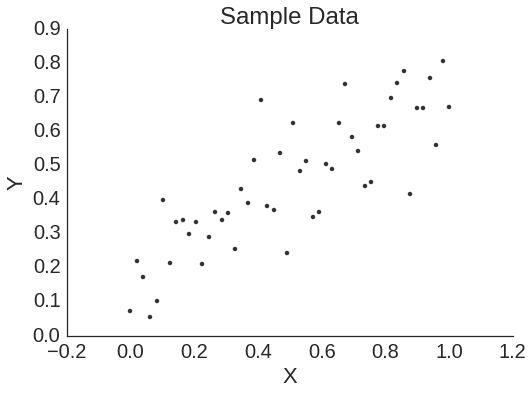

In [3]:
x, y = theModel(num = 50)
ax = sns.regplot(x, y, fit_reg=False, color='black', label="Data")

ax.set(xlabel='X', ylabel='Y', title='Sample Data')
sns.despine(offset=0, trim=True)

----

### Polynomial Fitting

A simple first step is to see how different polynomial functions fit our
data. The numpy library includes a [polyfit][npf] function that will fit
a polynomial of a a given order to a data set. The best fit is
determined by minimizing the squared error (between known and fitted
values). With this function, we can look at how different polynomials
model our data.

-----
[npf]: http://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html



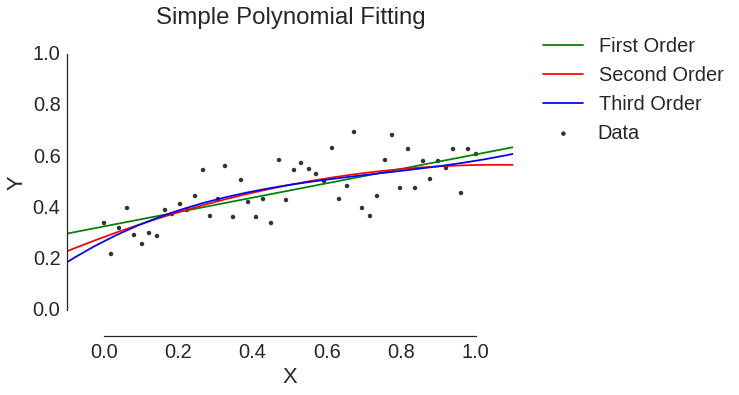

In [4]:
x, y = theModel(num = 50)
ax = sns.regplot(x, y, fit_reg=False, color='black', label="Data")

xf = np.linspace(-0.20,1.2,25)

pf1 = np.poly1d(np.polyfit(x, y, 1))
plt.plot(xf, pf1(xf), c='g', label="First Order")

pf2 = np.poly1d(np.polyfit(x, y, 2))
plt.plot(xf, pf2(xf), c='r', label="Second Order")

pf3 = np.poly1d(np.polyfit(x, y, 3))
plt.plot(xf, pf3(xf), c='b', label="Third Order")

#pfn = np.poly1d(np.polyfit(x, y, 10))
#plt.plot(xf, pfn(xf), c='b', label="High Order")

ax.set(title='Simple Polynomial Fitting',
       xlabel='X', xlim=(-0.1, 1.1),
       ylabel='Y', ylim=(-0.1, 1.1))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #loc=4)
sns.despine(offset=0, trim=True)

-----

This previous plot is important for a multitude of reasons. Notice how
each polynomial fits the data quite well over the range of the
independent variable (i.e., `x`). This range is often described as the
_support_, since these data values are used to fit or train the model.
Outside this range, the functions have no support, and are thus
unconstrained. This is shown in the figure by the (for some data)
rapidly diverging models beyond the supporting data. 

Second, as the polynomial order increases, we can eventually reach a
point of _overfitting_ the data. This can be easily seen by uncommenting
the two lines that fit a tenth order polynomial (you can change this
order and see the effect). In this case, the polynomial begins to
capture the fine details in the data distribution, which can often simply
be the result of noise in measurement processes. Overfitting is a major
concern when determining model fits, and overcoming this issue leads us
into more formal model fitting methods.

-----

## Linear Regression

The polynomial fitting demonstrated earlier in this notebook provides a
nice method for quickly generating a model approximation to a data set.
However, it uses a fixed fitting criterion and thus is less flexible
than we might like. The formal method of determining a best fitting
model is known as regression, and the most common implementation is
known as [**Linear Regression**][lrw]. linear regression models can be
quantified by using a least squares approach, or they can be determined
by using an alternative fit criteria such as least absolute deviations
or penalty or loss function. An important concept with linear regression
is that the _linear_ term does not refer to the functional order of the
input features, but to the parameters that multiply these features.
Thus, a linear regression can involve polynomials or other functions of
the features, although we will not discuss this in the current Notebook.

### Statsmodels

In the next few code blocks, we employ the statsmodel library to perform
ordinary least squares on our generated data set. [Statsmodels][sm] is a
Python library that implements a number of statistical methodology,
often in concert with Pandas. We will first construct a Pandas DataFrame
from our generated data, before adding in a constant column (or feature)
so that our fit will have two parameters: an intercept and a slope. We
then use the built-in fitting in Seaborn to show the expected result
(note that Seaborn also automatically displays the confidence intervals,
which are not discussed in this Notebook).

-----
[lrw]: https://en.wikipedia.org/wiki/Linear_regression
[sm]: http://statsmodels.sourceforge.net

In [5]:
import statsmodels.api as sm

df = pd.DataFrame({'x': x, 'y': y})
df = sm.add_constant(df)  # add constant as we did before
df.head()

,const,x,y
0,1,0.000000,0.339547
1,1,0.020408,0.221472
2,1,0.040816,0.321322
3,1,0.061224,0.398301
4,1,0.081633,0.292968


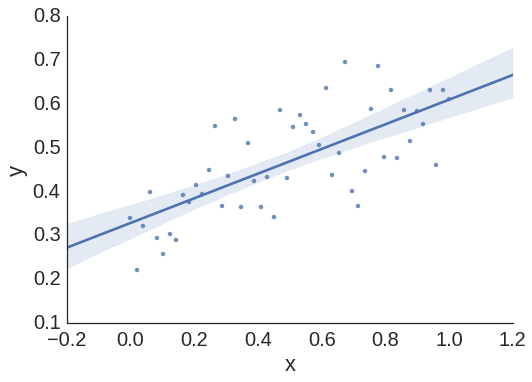

In [6]:
ax = sns.regplot('x', 'y', df, fit_reg=True)

sns.despine(offset=0, trim=True)

-----

Now that we have an appropriate DataFrame, we can easily employ the
formulaic interface to obtain an ordinary least squares fit to the data
of interest. The formulaic interface is borrowed from `R`, and simply
relates the result to the features. In our case, we map the `y` label to
the x features in the first example, this will include the constant term
in the calculation. In the second example, we remove the constant term to
obtain the best fit line with zero intercept (simply for comparison).
After we calculate these two fits, we plot the data and fits for a
visual analysis of the results.

-----

In [7]:
import statsmodels.formula.api as smf

# Implement simple regression: Result ~ Input

# First we fit slope and intercept
result = smf.ols(formula='y ~ x', data=df).fit()

# Fit a no intercept line
result_noi = smf.ols(formula='y ~ x - 1', data=df).fit()


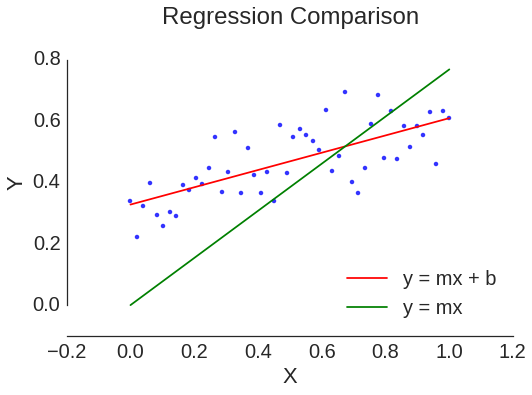

In [8]:
ax = sns.regplot('x', 'y', df, fit_reg=False, color='blue')

# We pick 100 hundred points equally spaced from the min to the max
xfpd = pd.DataFrame({'xfpd': np.linspace(0, 1, 50)})

yfi = result.predict(xfpd)
yfi_noi = result_noi.predict(xfpd)

plt.plot(xfpd['xfpd'], yfi, color='red', label='y = mx + b')
plt.plot(xfpd['xfpd'], yfi_noi, color='green', label='y = mx')

ax.set(xlabel='X', ylabel='Y', title='Regression Comparison')
ax.legend(loc=4)
sns.despine(offset=0, trim=True)

-----

One benefit of using the statsmodels fitting method is the wealth of
information that can be accessed about the quality of the fit and the
model parameters. Given a model fit, we simply call the `summary` method
to display fitting parameters, information, and quality metrics.

-----

In [9]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     50.43
Date:                Wed, 09 Sep 2015   Prob (F-statistic):           5.14e-09
Time:                        21:13:52   Log-Likelihood:                 54.775
No. Observations:                  50   AIC:                            -105.5
Df Residuals:                      48   BIC:                            -101.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.3276      0.023     14.238      0.000         0.281     0.374
x              0.2816      0.040      7.102      0.000         0.202     0.361
==============================================================================
Omnibus:                        1.219   Durbin-Watson:                   2.181
Prob(Omnibus):                  0.544   Jarque-Bera (JB):                1.131
Skew:                           0.209   Prob(JB):                        0.568
Kurtosis:                       2.393   Cond. No.                         4.31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
result_noi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     284.7
Date:                Wed, 09 Sep 2015   Prob (F-statistic):           4.74e-22
Time:                        21:13:52   Log-Likelihood:                 13.446
No. Observations:                  50   AIC:                            -24.89
Df Residuals:                      49   BIC:                            -22.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x              0.7681      0.046     16.872      0.000         0.677     0.860
==============================================================================
Omnibus:                        6.853   Durbin-Watson:                   0.420
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                2.971
Skew:                          -0.305   Prob(JB):                        0.226
Kurtosis:                       1.973   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-----

The statsmodel library also provides a traditional functional approach
to fitting, in which we pass in the original numpy arrays, calculate the
fit, and apply the result. In the following example, we fit a linear
relationship with a zero intercept (so only the slope varies) to our
generated data. Thus, our results should be (and are) identical to the
`result_noi` fit we obtained previously with the formulaic approach.

-----

In [11]:
ols_fit = sm.OLS(y, x)
ols_fit = ols_fit.fit()
ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     284.7
Date:                Wed, 09 Sep 2015   Prob (F-statistic):           4.74e-22
Time:                        21:13:52   Log-Likelihood:                 13.446
No. Observations:                  50   AIC:                            -24.89
Df Residuals:                      49   BIC:                            -22.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.7681      0.046     16.872      0.000         0.677     0.860
==============================================================================
Omnibus:                        6.853   Durbin-Watson:                   0.420
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                2.971
Skew:                          -0.305   Prob(JB):                        0.226
Kurtosis:                       1.973   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-----

### Scikit Learn

The most commonly used statistical and machine learning library in
Python is the [scikit learn][skl] library. This library includes a
number of different model fitting techniques (in addition to general
regression and classification algorithms) that can be easily applied to
a data set. While we will focus below on the linear regression
estimator, the scikit learn library includes a number of other
estimators that can be used to improve model fits while minimizing the
risk of overfitting, including

- Ridge Regression
- Lasso
- Elastic Net
- Orthogonal Matching Pursuit
- Bayesian regression
- Stochastic Gradient Descent
- Robust regression

To learn about these more advanced techniques, see the relevant library
documentation page. 

In the following code cells, we use the `LinearRegression` estimator
within the scikit learn library to fit our sample data, plot the
results, and finally display the fit coefficients.

-----
[skl]: http://scikit-learn.org/stable/index.html

y = 0.33 + 0.28 x


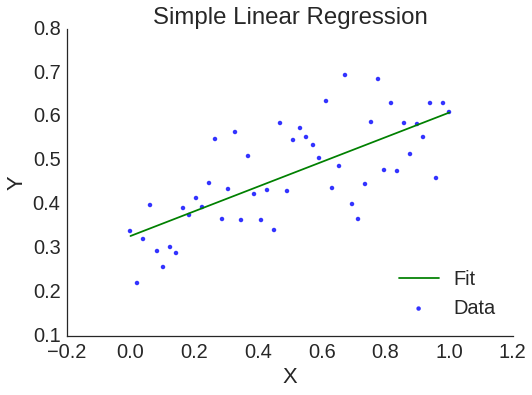

In [12]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x[:, np.newaxis], y)

# Plot the data and the model prediction
xf = np.linspace(0, 1, 25)
yf = model.predict(xf[:, np.newaxis])

ax = sns.regplot(x, y, fit_reg=False, color='blue', label="Data")

ax.set(xlabel='X', ylabel='Y', title='Simple Linear Regression')
plt.plot(xf, yf, c='g', label="Fit")
ax.legend(loc=4)
sns.despine(offset=0, trim=True)

print("y = {0:4.2f} + {1:4.2f} x".format(model.intercept_, model.coef_[0]))

-----

#### Cross-Validation

To this point, we have used all of our data to fit a model, and generate
new data samples to test the model fit. Often, we only have  single data
set, yet we still want to quantify the quality of a particular fit. In
this case, we can employ the scikit learn libraries cross-validation
implementation, where we split our data set into a training sample and a
testing sample. The training data are used to construct the model, and
the testing data quantify the quality of the fit. This is demonstrated
in the following code cells, where we split our data `60:40` into
training and testing data, before computing a linear regression and
visually analyzing the result.

-----

In [13]:
#Now plot the data
from sklearn.cross_validation import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6)

y = 0.33 + 0.24 x
MSE = 0.009


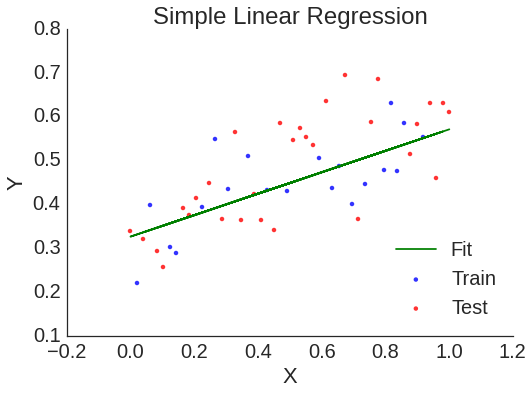

In [14]:
model = LinearRegression()
model.fit(x_train[:, np.newaxis], y_train)

# Plot the data and the model prediction
#xf = np.linspace(0, 1, 25)
yf = model.predict(x_test[:, np.newaxis])

ax = sns.regplot(x_train, y_train, fit_reg=False, color='blue', label="Train")
ax = sns.regplot(x_test, y_test, fit_reg=False, color='red', label="Test")


ax.set(xlabel='X', ylabel='Y', title='Simple Linear Regression')
plt.plot(x_test, yf, c='g', label="Fit")
ax.legend(loc=4)
sns.despine(offset=0, trim=True)


print("y = {0:4.2f} + {1:4.2f} x".format(model.intercept_, model.coef_[0]))
print("MSE = {0:5.3f}".format(np.mean((yf-y_test)**2)))

-----

#### Fit Metrics

The scikit learn library provides several functions that can be used to
obtain metrics that quantify the quality of the model fit. These
functions are in the `metrics` module, and include the _mean absolute
error_ and the _mean squared error_. The second metric and also be used
to compute the _root mean squared error_, which is a popular fit metric.
These three metrics are all demonstrated in the following code block.

-----

In [15]:
from sklearn import metrics

print("MAE = {:5.4f}".format(metrics.mean_absolute_error(y_test, yf)))
print("MSE = {:5.4f}".format(metrics.mean_squared_error(y_test, yf)))
print("RMSE = {:5.4f}".format(np.sqrt(metrics.mean_squared_error(y_test, yf))))

MAE = 0.0769
MSE = 0.0087
RMSE = 0.0931


-----

#### Machine Learning Regression

One of the primary benefits of using the scikit learn library is the
simplicity with which one can switch between different model fitting
algorithms. To demonstrate this for our regression example, we can
switch from a `LinearRegression` model to a `RandomForestRegression`
model. Other than this name change (which involves a different import
statement and model creation), the rest of the code is nearly identical.

In the end, this approach should be used with caution, as demonstrated
below. Our random forest regressor clearly overfits the data, which is
primarily a manifestation of too small of a training set. With much
larger data sets, this alternative model can be a useful technique for
developing a model representation of a (potentially) multi-dimensional
data set.

-----

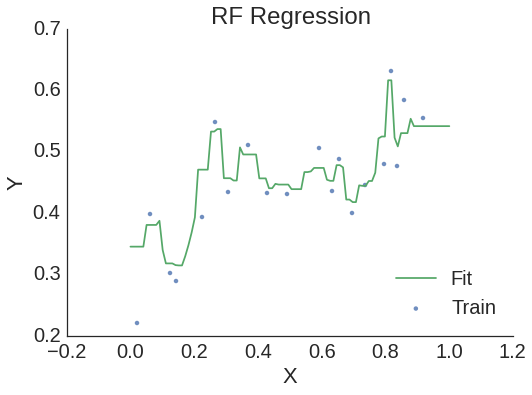

In [16]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(10)
rf_model.fit(x_train[:, np.newaxis], y_train)

xf = np.linspace(0, 1, 100)[:, np.newaxis]
yf = rf_model.predict(xf)

ax = sns.regplot(x_train, y_train, fit_reg=False, label="Train")

ax.set(xlabel='X', ylabel='Y', title='RF Regression')
plt.plot(xf, yf, label="Fit")

ax.legend(loc=4)
sns.despine(offset=0, trim=True)

-----

### Regression Example

After the previous discussion, we can now move onto a real data
analysis. In this case, we can build on the analysis presented in the
[Python Data Exploration][pde] notebook, where we plotted the departure
and arrival delays, which indicated a fairly strong relationship. Of
course this is expected, a flight that is late to depart is likely late
to arrive, but how close is this relationship to a linear function with,
for example, a zero intercept? TO answer this question, we first read
the data into this notebook, before restricting the data to a single
airport (O'Hare in this initial example) and removing rows with missing
data. Before constructing a linear regression, we also use Seaborn to
plot the dta along with a best fit linear relation.

-----
[pde]: ./pyde.ipynb#Advanced-Data-Processing

In [17]:
# Change this to read a different file, for example
# /home/data_scientist/data/2001.csv on the JupyterHub Server
#
# Note that the JupyterHub server has data from other years in the raw
# subdirectory.
#
filename = '/home/data_scientist/rppdm/data/2001.csv'

# Read select columns for all rows.

ucs = (1, 2, 4, 14, 15, 16, 17, 18)
cnms = ['Month', 'Day', 'dTime', 'aDelay', 'dDelay', 'Depart', 'Arrive', 'Distance']

alldata = pd.read_csv(filename, header=0, na_values=['NA'], usecols=ucs, names=cnms)


In [18]:
local = alldata.loc[alldata['Depart'] == 'ORD'].dropna()
local.describe()

,Month,Day,dTime,aDelay,dDelay,Distance
count,321784.000000,321784.000000,321784.000000,321784.000000,321784.000000,321784.000000
mean,6.354067,15.714224,1386.255721,8.916938,11.812635,769.109138
std,3.382844,8.850686,466.639178,36.284050,31.590608,524.643619
min,1.000000,1.000000,1.000000,-67.000000,-43.000000,67.000000
25%,3.000000,8.000000,1004.000000,-10.000000,-2.000000,334.000000
50%,6.000000,16.000000,1356.000000,-1.000000,0.000000,678.000000
75%,9.000000,23.000000,1811.000000,14.000000,11.000000,925.000000
max,12.000000,31.000000,2400.000000,1473.000000,1477.000000,4243.000000


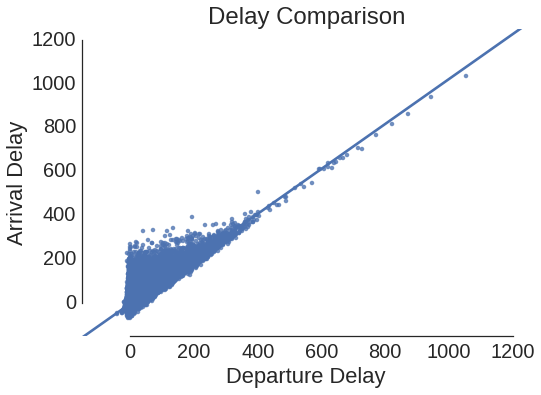

In [19]:
# Make a scatter plot and fit a linear regression

ax = sns.regplot(data=local, x='dDelay', y='aDelay')

ax.set(title='Delay Comparison',
       xlabel='Departure Delay', xlim=(-150, 1250),
       ylabel='Arrival Delay', ylim=(-150, 1250))

sns.despine(offset=0, trim=True)

-----

Clearly there is a fairly strong linear relationship, with large scatter
at small departure delays. This should make sense, since flights can be
much longer than a small departure delay of even ten or twenty minutes.
Our next step is to construct a new DataFrame to hold our feature and
label, add a constant column as before to also fit an intercept before
obtaining our least squares fit. Finally we overplot the data and the
best fit, along with the fit coefficients, showing the best fit line
does not have a zero intercept.

-----

In [20]:
df = local[['dDelay', 'aDelay']]
df = sm.add_constant(df)  # add constant as we did before
df.head()

,const,dDelay,aDelay
6367,1,-8,-9
6368,1,0,-6
6369,1,13,34
6370,1,17,18
6371,1,-1,-10


In [21]:
result = smf.ols(formula='aDelay ~ dDelay', data=df).fit()

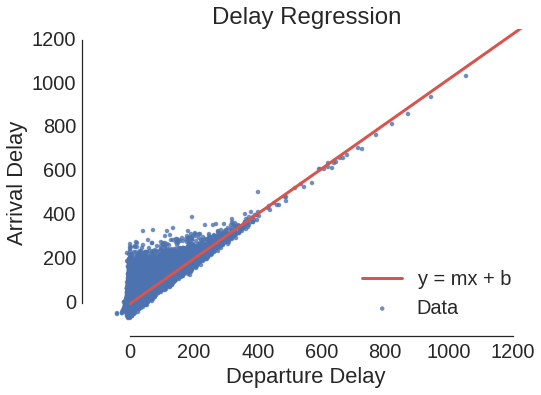

In [22]:
ax = sns.regplot('dDelay', 'aDelay', df, fit_reg=False, label='Data')

# We pick 100 hundred points equally spaced from the min to the max
xfpd = pd.DataFrame({'dDelay': np.linspace(0, 1500, 50)})

yfi = result.predict(xfpd)

plt.plot(xfpd['dDelay'], yfi, sns.xkcd_rgb["pale red"], lw=3, label='y = mx + b')

ax.set(title='Delay Regression',
       xlabel='Departure Delay', xlim=(-150, 1250),
       ylabel='Arrival Delay', ylim=(-150, 1250))

ax.legend(loc=4)
sns.despine(offset=0, trim=True)

In [23]:
print("y = {0:4.2f} + {1:4.2f} x".format(model.intercept_, model.coef_[0]))

y = 0.33 + 0.24 x


-----
## Breakout Session

During this breakout, you should work through these examples more
carefully in order to gain more confidence with regression. Specific
problems you can attempt include the following:

1. Extend the range spanned by the support features (i.e., `x`) and the
number of samples (i.e., the length of the `x` and `y` vectors). Use the
new data to explore higher order polynomial fits.

2. Explore the dependence of test data quantity on the linear fit with
the new data.

3. Implement a second order polynomial fit with StatsModel.

Additional, more advanced problems:

1. Implement a second order polynomial fit to the worked airline data
set.

2. Implement a linear fit to the airline flight data, but include
additional features such as `DayofMonth`, `Month`, and `Distance`.

As time permits, You can use the data stored on our JupyterHub server to
see how the figures in this Notebook change when analyzing flight data
from a different year.

-----

### Additional References

2. [StatsModels][smols] Ordinary Least Squares.
3. [Generalized Linear Models][glm] with Scikit Learn.
3. [Discussion][dsc] on StatsModels and Scikit Learn libraries.
-----
[smols]: http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/ols.html
[glm]: http://scikit-learn.org/stable/modules/linear_model.html
[dsc]: http://stats.stackexchange.com/questions/47913/pandas-statsmodel-scikits-learn

### Return to the [Week One](index.ipynb) index.

-----